In [23]:
from typing import List, Tuple, Any, Dict, TypeVar

from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import cauchy
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm

SklearnClass = TypeVar("SklearnClass") # The class itself (e.g. DecisionTreeRegressor)
SklearnModel = TypeVar("SklearnModel") # The model itself (e.g. DecisionTreeRegressor(max_depth=1))

In [24]:
random_seed = 42
np.random.seed(42)

In [25]:
deep_grey = '#3B4856' # основной тёмный / холодный цвет
sky_blue = '#348FEA'
marine_green = '#4CB9C0'
grass_green = '#97C804'
medium_yellow = '#FFC100' # основной светлый / тёплый цвет
sicilian_orange = '#E06A27'
fuchsia_pink = '#C81D6B'
saturated_violet = '#5002A7'
navy_blue = '#292183'
cool_white = '#F5FBFF'

In [26]:
def f(x: np.ndarray) -> np.ndarray:
  return x * np.sin(x)

def generate_data(n_samples: int = 50, noise: float = 3, n_noise_samples: int = 1) -> Tuple[np.ndarray, np.ndarray]:
  x = np.random.rand(n_samples) * 20 - 10
  x = np.sort(x)

  y = np.zeros((n_samples, n_noise_samples))
  for i in range(n_noise_samples):
    y[:, i] = f(x) + np.random.normal(0.0, noise, n_samples)

  return x.reshape((n_samples, 1)), y.squeeze()


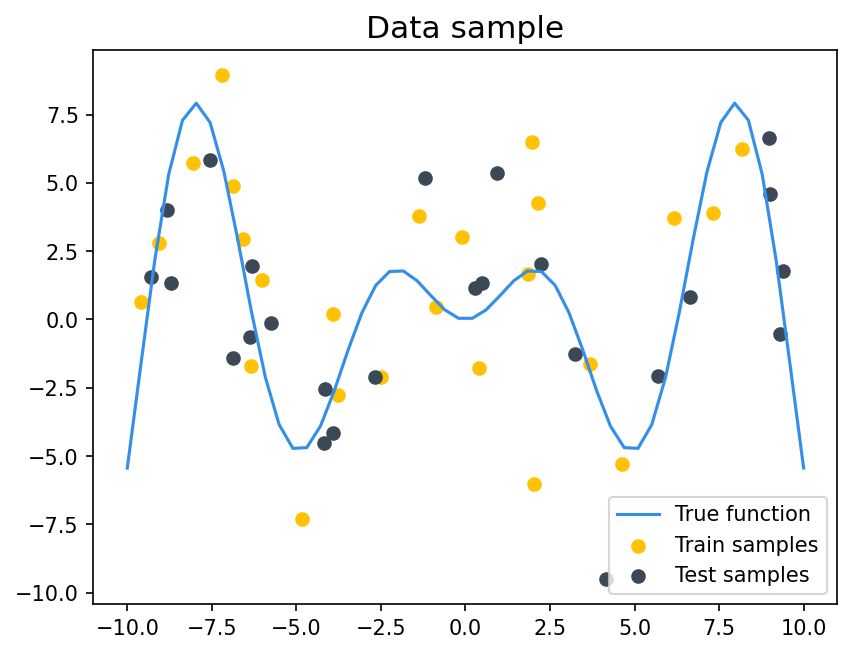

In [27]:
x, y = generate_data(noise=3)
x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size = 0.5)

plt.figure(dpi=150)
plt.title('Data sample', fontsize=15)
plt.plot(np.linspace(-10, 10), f(np.linspace(-10, 10)), color=sky_blue, label="True function")
plt.scatter(x_train, y_train, color=medium_yellow, label='Train samples')
plt.scatter(x_test, y_test, color=deep_grey, label='Test samples')
plt.legend()
plt.show()

In [28]:
def train_classifier_on_random_subset(clf_class: SklearnClass, parameters: Dict[str, Any],
                                      n_train_samples: int = 20, noise: float = 3) -> Tuple[SklearnModel, List[np.ndarray]]:
  x_train, y_train = generate_data(n_samples=n_train_samples, noise=noise)
  clf = clf_class(**parameters)
  clf.fit(x_train, y_train)
  return clf, x_train, y_train


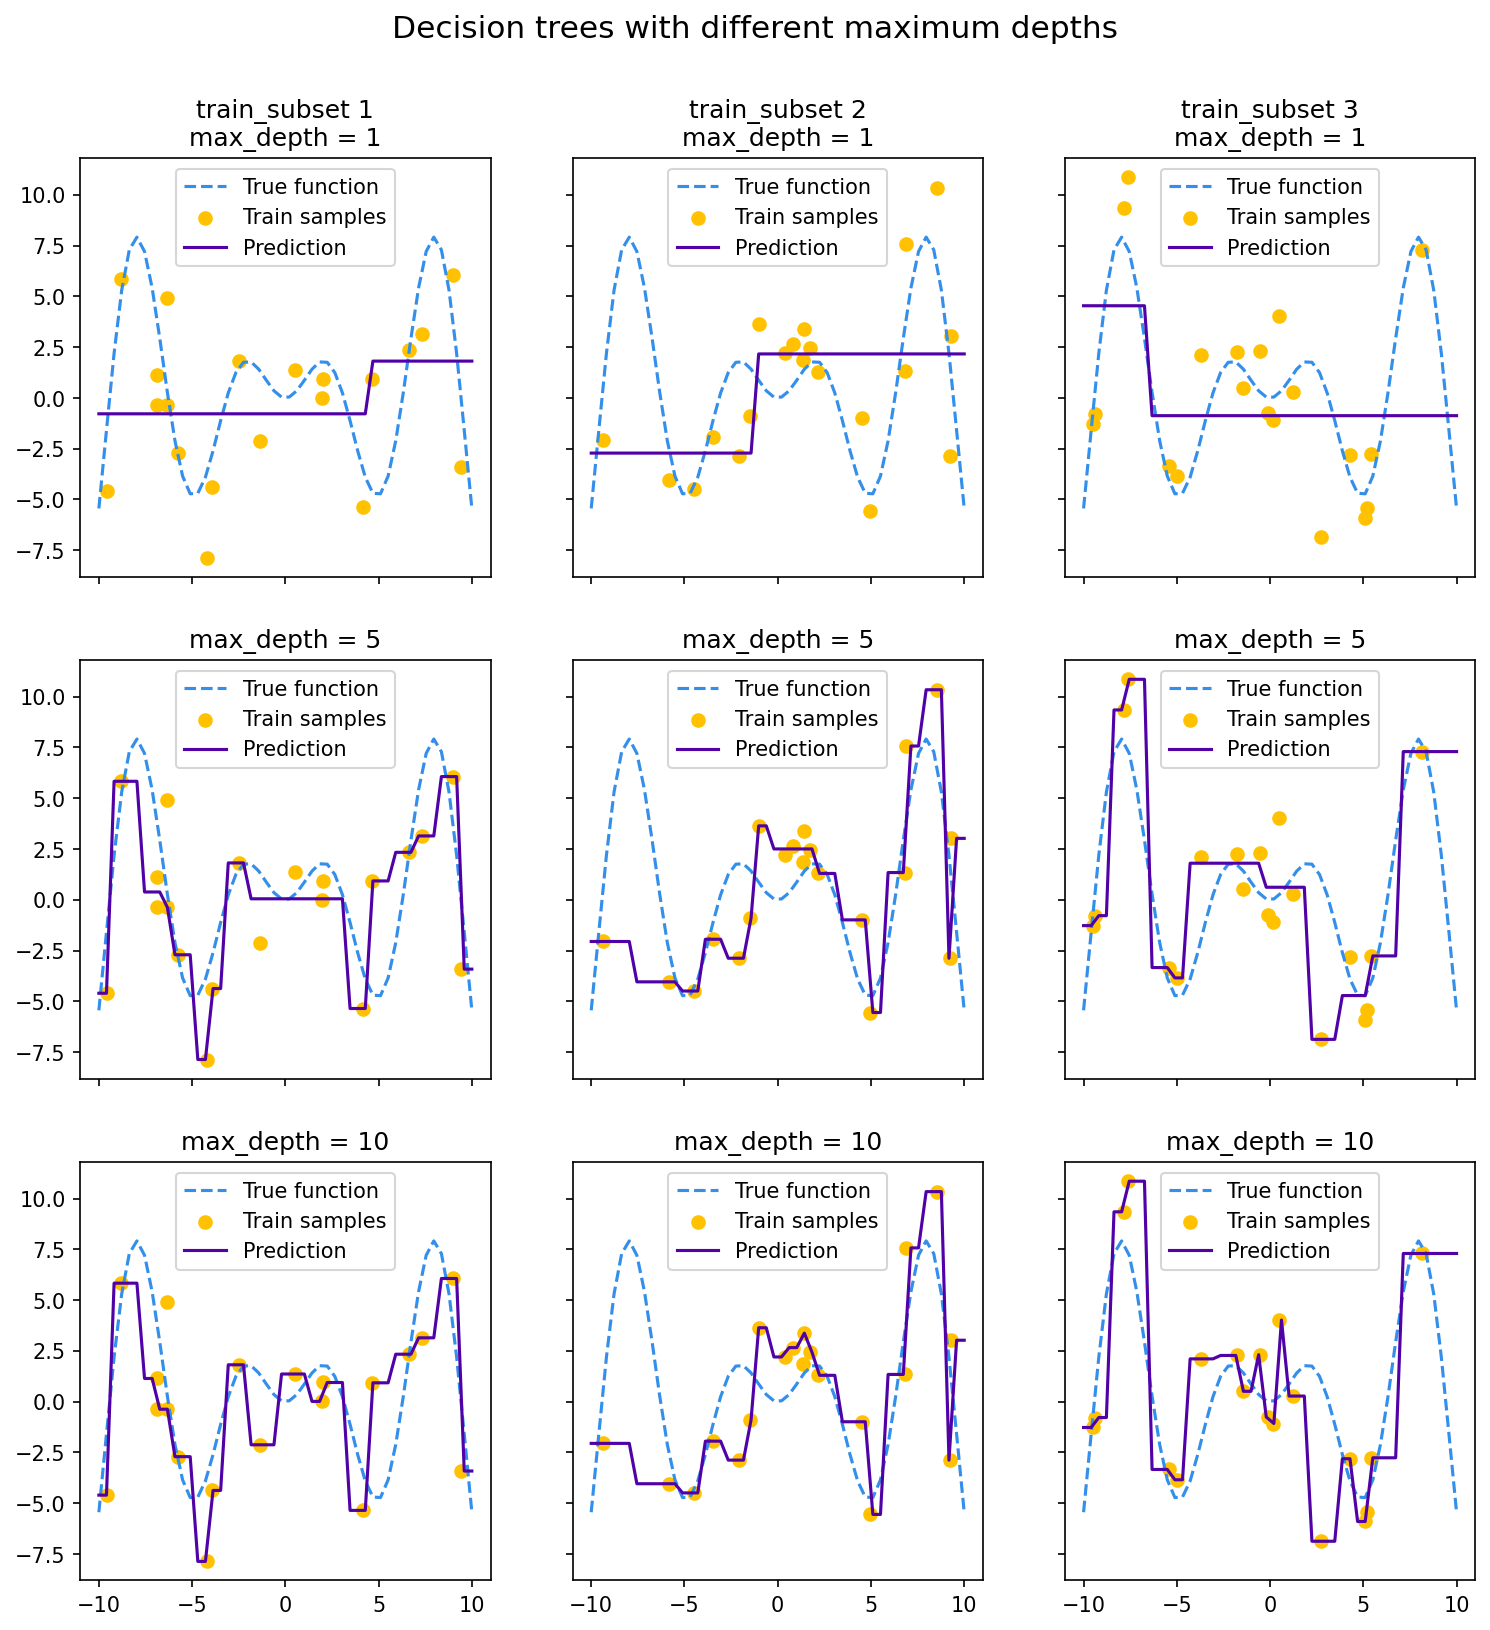

In [29]:
classifiers = [
    [DecisionTreeRegressor, {'max_depth': 1}],
    [DecisionTreeRegressor, {'max_depth': 5}],
    [DecisionTreeRegressor, {'max_depth': 10}]
]
n_tries = 3
x_ticks = np.linspace(-10, 10)
n_rows, n_cols = len(classifiers), n_tries
fig, ax = plt.subplots(n_rows, n_cols, figsize=(4 * n_rows, 4 * n_cols), dpi=150, sharex=True, sharey=True)
fig.subplots_adjust(top=0.9)
fig.suptitle("Decision trees with different maximum depths", fontsize=15)

for i, (clf_class, parameters) in enumerate(classifiers):
  np.random.seed(random_seed)
  for j in range(n_tries):
    clf, x_train, y_train = train_classifier_on_random_subset(
        clf_class = clf_class, parameters=parameters, noise=3
    )
    prediction = clf.predict(x_ticks[:, None])

    ax[i, j].plot(x_ticks, f(x_ticks), color=sky_blue, label="True function", linestyle='--')
    ax[i, j].scatter(x_train, y_train, color=medium_yellow, label="Train samples")
    ax[i, j].plot(x_ticks, prediction, color=saturated_violet, label="Prediction")
    title = "max_depth = {max_depth}".format(**parameters)
    if i == 0:
      title = f"train_subset {j + 1}\n" + title
    ax[i, j].set_title(title)
    ax[i, j].legend()

In [30]:
def get_predictions(
    classifiers: List[Tuple[SklearnClass, Dict[str, Any]]],
    n_tries: int, noise: float, n_train_samples: int,
    n_test_samples: int, n_noise_samples: int) -> List[Dict[int, Any]]:

    x_test, y_test = generate_data(n_samples=n_test_samples, n_noise_samples=n_noise_samples, noise=noise)

    predictions = defaultdict(list)

    for i, (clf_class, parameters) in enumerate(classifiers):
      np.random.seed(random_seed)
      for j in tqdm(range(n_tries), desc=f"{clf_class.__name__}, {parameters}"):
        clf, _, _ = train_classifier_on_random_subset(
            clf_class=clf_class,
            n_train_samples=n_train_samples,
            parameters=parameters
        )
        predictions[i].append(clf.predict(x_test))

    results = []
    for i, (clf_class, parameters) in enumerate(classifiers):
      results.append({
          'name': clf_class.__name__,
          'parameters': parameters,
          'predictions': np.stack(predictions[i]),
          'x_test': x_test,
          'y_test': y_test
      })
    return results

In [31]:
classifiers = [[DecisionTreeRegressor, {"max_depth": depth}] for depth in range(1, 16)]

results = get_predictions(
    classifiers,
    n_tries=1000,
    n_test_samples=500,
    n_train_samples=500,
    n_noise_samples=300,
    noise=3
)

DecisionTreeRegressor, {'max_depth': 15}: 100%|██████████| 1000/1000 [00:02<00:00, 469.91it/s]


In [32]:
print(f"predictions shape: n_tries × n_test_samples = {results[0]['predictions'].shape}")
print(f"x_test shape: n_test_samples × 1 = {results[0]['x_test'].shape}")
print(f"y_test shape: n_test_samples × n_noise_samples = {results[0]['y_test'].shape}")

predictions shape: n_tries × n_test_samples = (1000, 500)
x_test shape: n_test_samples × 1 = (500, 1)
y_test shape: n_test_samples × n_noise_samples = (500, 300)


In [33]:
def get_bias_variance(results: Dict[int, Any]) -> pd.DataFrame:
  records = []
  for res in results:
    x_test, y_test = res['x_test'], res['y_test']
    predictions = res['predictions']
    bias = f(x_test).squeeze() - np.mean(predictions, axis=0)
    variance = np.var(predictions, axis=0)
    noise = np.var(y_test, axis=1)
    error = (predictions[..., None] - y_test[None]) ** 2

    records.append({
      'name': res['name'],
      'parameters': res['parameters'],
      'bias_sq': np.mean(bias ** 2),
      'variance': np.mean(variance),
      'noise': np.mean(noise),
      'error': np.mean(error),
      'decomposition': np.mean(bias ** 2 + variance + noise)
    })

  return pd.DataFrame.from_records(records)

In [34]:
get_bias_variance(results)

,name,parameters,bias_sq,variance,noise,error,decomposition
0,DecisionTreeRegressor,{'max_depth': 1},9.538297,1.659189,8.971014,20.168596,20.168500
1,DecisionTreeRegressor,{'max_depth': 2},5.085339,1.650574,8.971014,15.740351,15.706927
2,DecisionTreeRegressor,{'max_depth': 3},2.129631,2.077819,8.971014,13.215631,13.178464
3,DecisionTreeRegressor,{'max_depth': 4},0.423197,1.748217,8.971014,11.174658,11.142428
4,DecisionTreeRegressor,{'max_depth': 5},0.145411,1.829574,8.971014,10.976485,10.945999
5,DecisionTreeRegressor,{'max_depth': 6},0.038503,2.521282,8.971014,11.558981,11.530799
6,DecisionTreeRegressor,{'max_depth': 7},0.010943,3.398563,8.971014,12.406634,12.380520
7,DecisionTreeRegressor,{'max_depth': 8},0.005651,4.316676,8.971014,13.319238,13.293341
8,DecisionTreeRegressor,{'max_depth': 9},0.004785,5.222025,8.971014,14.224730,14.197823
9,DecisionTreeRegressor,{'max_depth': 10},0.005293,6.046066,8.971014,15.049149,15.022374


In [35]:
def plot_bias_variance(
    bias_variance_results: pd.DataFrame,
    target_parameter_name: str,
    target_parameter_values: List[float]
) -> None:

    plt.figure(figsize=(8, 5), dpi=150)
    plt.xticks(target_parameter_values)

    plt.plot(
        target_parameter_values,
        bias_variance_results.bias_sq,
        label=r"$\mathbb{E}_x \, bias_x^2$",
        color=navy_blue
    )

    plt.plot(
        target_parameter_values,
        bias_variance_results.variance,
        label=r"$\mathbb{E}_x \, variance_x$",
        color=sicilian_orange
    )

    plt.plot(
        target_parameter_values,
        bias_variance_results.noise,
        label=r"$\sigma^2$",
        color=grass_green
    )

    plt.plot(
        target_parameter_values,
        bias_variance_results.error,
        label="MSE",
        color=marine_green
    )

    plt.xlabel(target_parameter_name)
    plt.legend(fontsize=10, loc="upper right")
    plt.show()


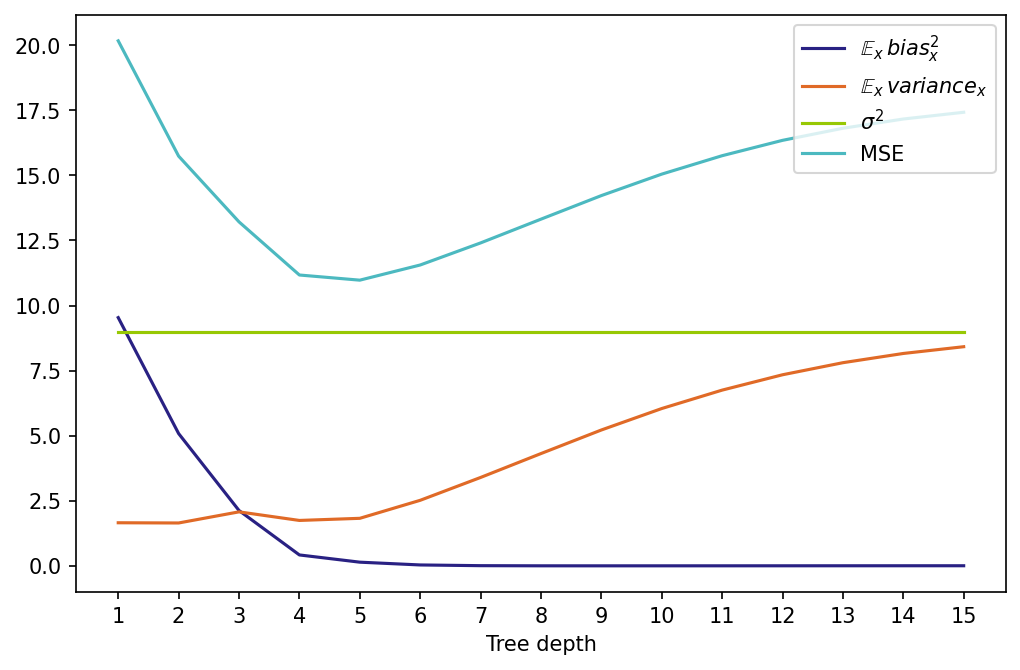

In [36]:
bias_variance_trees = get_bias_variance(results)
depth = bias_variance_trees.apply(lambda r: r.parameters['max_depth'], axis=1)

plot_bias_variance(bias_variance_trees, target_parameter_name='Tree depth', target_parameter_values=depth)

In [37]:
classifier = [[DecisionTreeRegressor, {'max_depth': depth}] for depth in range(1, 26)]

results = get_predictions(
    classifiers,
    n_tries=1000,
    n_test_samples=500,
    n_train_samples=500,
    n_noise_samples=300,
    noise=3
)

DecisionTreeRegressor, {'max_depth': 15}: 100%|██████████| 1000/1000 [00:02<00:00, 358.43it/s]


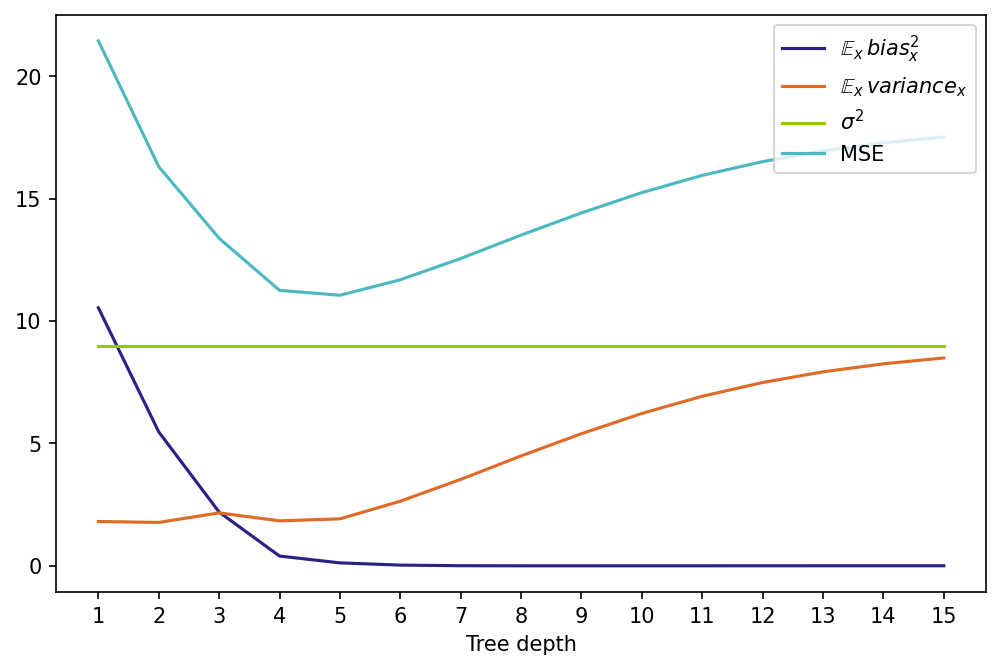

In [38]:
bias_variance_many_trees = get_bias_variance(results)
plot_bias_variance(bias_variance_many_trees, target_parameter_name='Tree depth', target_parameter_values=depth)

In [46]:
class BaggingOnTrees(BaggingRegressor):
    def __init__(self, max_depth: int, max_samples: int, n_estimators: int):
        self.max_depth = max_depth   # store as attribute
        estimator = DecisionTreeRegressor(max_depth=max_depth)
        super().__init__(estimator=estimator, max_samples=max_samples, n_estimators=n_estimators)

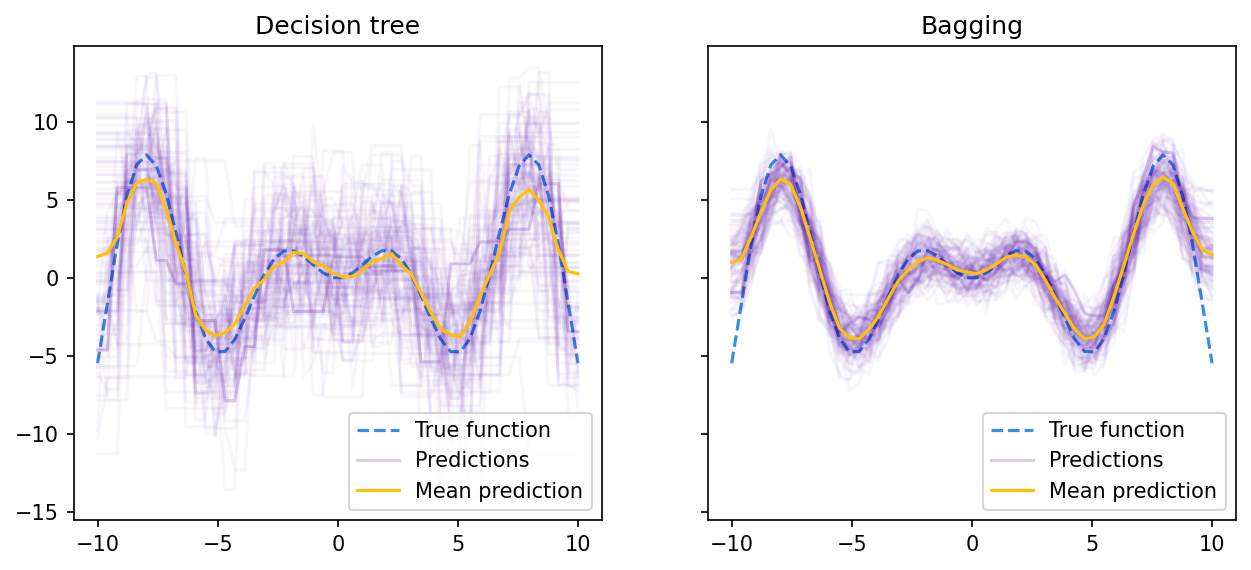

In [47]:
def plot_many_predictions(
    axs, x_ticks: np.ndarray, clf_class: SklearnClass,
    parameters: Dict[str, Any], n_tries: int, n_train_samples: int,
    title: str
) -> None:

    # plot true function first
    axs.plot(x_ticks, f(x_ticks), color=sky_blue, label="True function", linestyle="--")

    np.random.seed(random_seed)
    predictions = []

    for j in range(n_tries):
        clf, _, _ = train_classifier_on_random_subset(
            clf_class=clf_class,
            parameters=parameters,
            n_train_samples=n_train_samples,
            noise=3
        )

        prediction = clf.predict(x_ticks[:, None])
        predictions.append(prediction)

        # plot first prediction with higher alpha and label
        if j == 0:
            axs.plot(x_ticks, prediction, color=saturated_violet, alpha=0.2, label="Predictions")
        else:
            axs.plot(x_ticks, prediction, color=saturated_violet, alpha=0.04)

    # plot mean prediction over all tries
    mean_prediction = np.mean(np.stack(predictions), axis=0)
    axs.plot(x_ticks, mean_prediction, label="Mean prediction", color=medium_yellow)

    axs.set_title(title)
    axs.legend(loc="lower right")

n_tries = 100
x_ticks = np.linspace(-10, 10)
n_rows, n_cols = 1, 2
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 4), dpi=150, sharey=True)
fig.subplots_adjust(top=0.9)

plot_many_predictions(
    axs=ax[0], x_ticks=x_ticks, clf_class=DecisionTreeRegressor,
    parameters={"max_depth": 7},
    n_tries=n_tries, n_train_samples=20,
    title="Decision tree"
)

plot_many_predictions(
    axs=ax[1], x_ticks=x_ticks, clf_class=BaggingOnTrees,
    parameters={"max_samples": 20, "n_estimators": 10, "max_depth": 7},
    n_tries=n_tries, n_train_samples=10000,
    title="Bagging"
)

plt.show()

In [48]:
classifiers = [[BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': depth}] for depth in range(1, 16)]

results = get_predictions(
    classifiers,
    n_tries=100,
    n_test_samples=500,
    n_train_samples=10000,
    n_noise_samples=300,
    noise=3
)

BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 1}: 100%|██████████| 100/100 [00:03<00:00, 27.91it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 2}: 100%|██████████| 100/100 [00:03<00:00, 32.37it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 3}: 100%|██████████| 100/100 [00:02<00:00, 35.45it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 4}: 100%|██████████| 100/100 [00:02<00:00, 34.47it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 5}: 100%|██████████| 100/100 [00:03<00:00, 29.39it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 6}: 100%|██████████| 100/100 [00:03<00:00, 27.85it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 7}: 100%|██████████| 100/100 [00:03<00:00, 31.26it/s]
BaggingOnTrees, {'max_samples': 500, 'n_estimators': 10, 'max_depth': 8}: 100%|██████████| 100/100 [00:03<00:00, 30.61it/s]
BaggingO

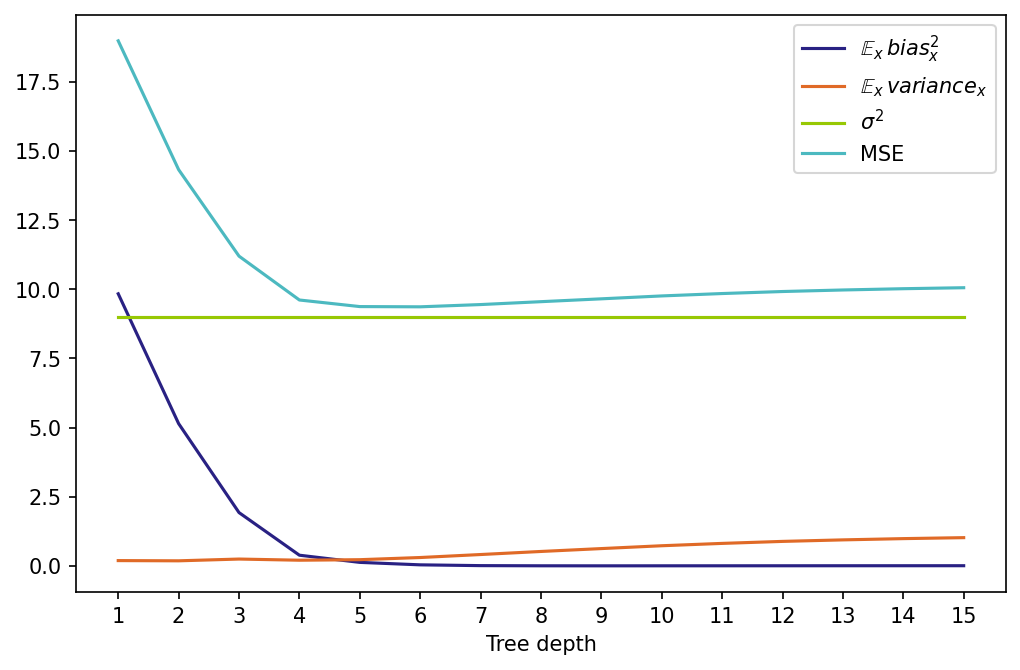

In [49]:
bias_variance_bagging = get_bias_variance(results)
plot_bias_variance(
    bias_variance_bagging, target_parameter_name='Tree depth',
    target_parameter_values=bias_variance_bagging.apply(lambda r: r.parameters['max_depth'], axis=1)
)

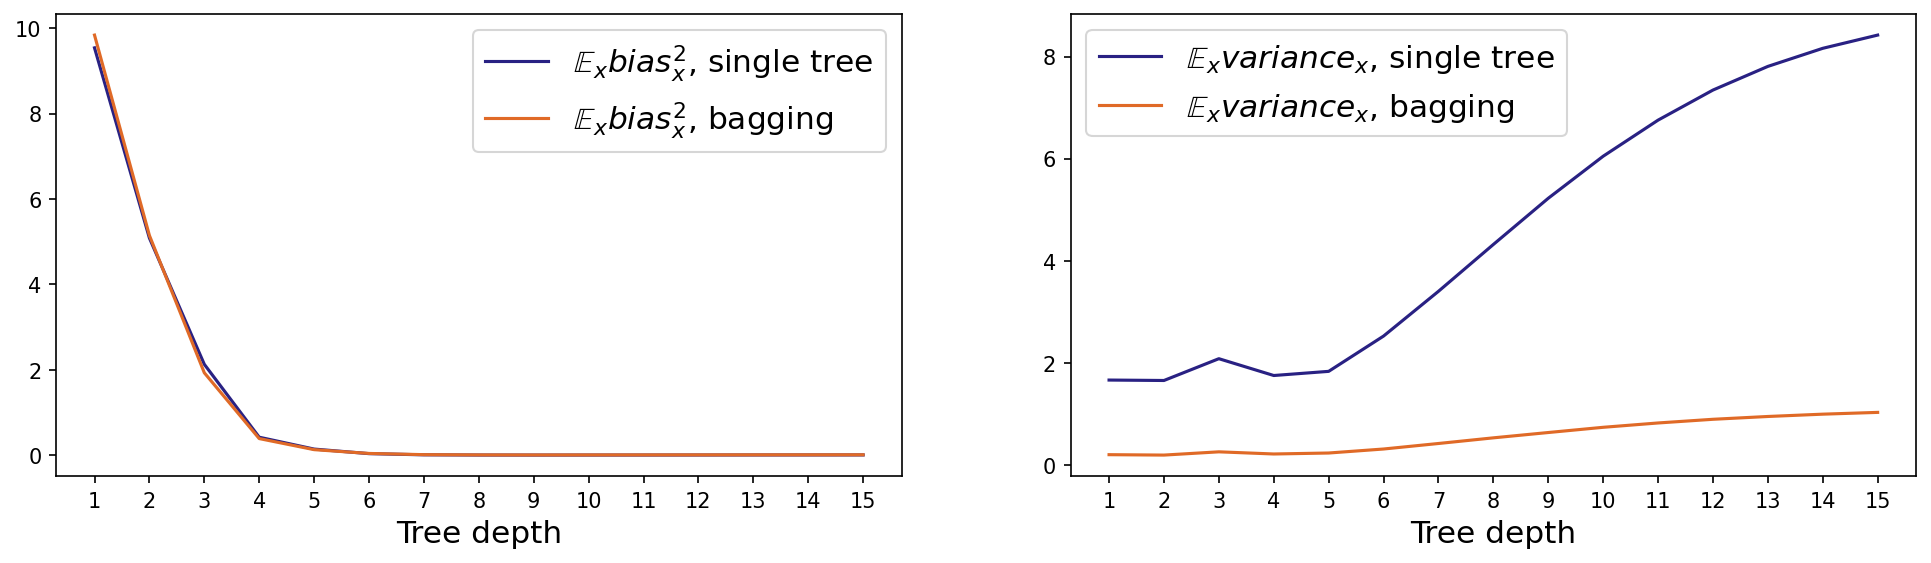

In [50]:
fig, ax = plt.subplots(1, 2, dpi=150, figsize=(16, 4))

# Plot bias squared
ax[0].set_xticks(depth)
ax[0].plot(depth, bias_variance_trees.bias_sq, label=r"$\mathbb{E}_x bias_x^2$, single tree", color=navy_blue)
ax[0].plot(depth, bias_variance_bagging.bias_sq, label=r"$\mathbb{E}_x bias_x^2$, bagging", color=sicilian_orange)
ax[0].set_xlabel("Tree depth", fontsize=15)
ax[0].legend(fontsize=15)

# Plot variance
ax[1].set_xticks(depth)
ax[1].plot(depth, bias_variance_trees.variance, label=r"$\mathbb{E}_x variance_x$, single tree", color=navy_blue)
ax[1].plot(depth, bias_variance_bagging.variance, label=r"$\mathbb{E}_x variance_x$, bagging", color=sicilian_orange)
ax[1].set_xlabel("Tree depth", fontsize=15)
ax[1].legend(fontsize=15)

plt.show()
